# RAG Evaluation

This is the final desiging step of our RAG, where we are going to evaluate the performance of the full RAG, using LLM as a judge, to select which of the alternatives of chunkig acchieve the best performance. There are a couple considerations to keep in mind before we beggin:

* Even though until this point we have used and tested the search process with the self defined algorithms, from a deployment perspective they are not ideal (mainly since the design would imply to re-deploy the RAG app every time a new document was added to the knowledge data base) therefore, taking into account that the best method for every case turned to be a hybrid search without RRF, we are going to use Elastich Search for our retireval part, adapting the findings form the optimization process. This might not be ideal but this project was mainly for learning reasons, so in my concept this is a good enough approach.
* For each scenario we will check different numbers of retrieved information, taking into account that the sentence splitting returns shorter texts.


## Libraries

In [2]:

import os
import sys
import json
import time
import pandas as pd

from dotenv import load_dotenv
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns

project_path = os.path.dirname(os.getcwd())
sys.path.append(project_path)

from src.db import ElasticsearchManager
from src.rag import RAG
from src.evaluation import evaluate

load_dotenv(override=True)

GOOGLE_API_KEY = os.environ['GOOGLE_API_KEY']
ELASTICSEARCH_HOST = os.getenv('ELASTICSEARCH_HOST', 'localhost')
ELASTICSEARCH_PORT = os.getenv('ELASTICSEARCH_PORT', '9200')
EMBEDDING_MODEL = os.getenv('EMBEDDING_MODEL', 'all-mpnet-base-v2')

# Just for searching trials
embbeding_model = SentenceTransformer(EMBEDDING_MODEL)

c:\Users\User\Documents\Cursos\llm_zoomcamp_final_project\llm-project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\User\Documents\Cursos\llm_zoomcamp_final_project\llm-project\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## RAG prompt template

We will implement a template to format each record retrieved into the context and another for the whole prompt.

In [3]:
entry_template = """
category: {category}
paper: {paper}
text: {text}
""".strip()
prompt_template = """
You are a research assistant specializing in various academic fields. 
Your task is to provide accurate and concise answers to questions based on the information extracted from the provided research papers.

**Question:** {question}

**Context:**

{context}

**Guidelines:**

* **Cite your sources:** If you reference specific information from a paper, include the paper title in parentheses, e.g., "(Attention is all You need)".
* **Prioritize relevance:** Only use information from the context that is directly relevant to the question.
* **Be concise:** Provide clear and focused answers without unnecessary elaboration.
* **Maintain academic tone:** Use language appropriate for an academic audience.
* **If the context doesn't contain enough information to fully answer the question, clearly state that you need more information or that the context doesn't address the question.**

**Answer:**
"""

## Elastic search manager

In the db module an elastic search manager class has been created to make it easier to interact with the database. Here we start by calling the class and initializing a manager object. Notice that the RAG class does this as well. Here we will use the direct call for data ingestion, and the one within the RAG class lather for evaluation.

In [4]:
es_manager = ElasticsearchManager(
    host=ELASTICSEARCH_HOST,
    port=ELASTICSEARCH_PORT,
    embedding_model_name=EMBEDDING_MODEL
)
es_manager.es_client.info()

ObjectApiResponse({'name': '460583f595c1', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'nryKXaJOTcabVMh369q9UQ', 'version': {'number': '8.4.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '42f05b9372a9a4a470db3b52817899b99a76ee73', 'build_date': '2022-10-04T07:17:24.662462378Z', 'build_snapshot': False, 'lucene_version': '9.3.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

## Data ingestion

### Sentence Splitting

In [5]:

df_sentence_splitting = pd.read_csv(
    os.path.join(project_path, 'data', 'testing', 'sentence_splitting.csv')
)
print(f"The data set contains: {df_sentence_splitting.shape[0]} sentences")
sentece_splitting_docs = df_sentence_splitting.to_dict(orient="records")
# Define search fields
text_fields = [
    'category',
    'paper',
    'text'
]
keyword_fields = ['id']
# Define the name for the experimental index
ss_index_name="sentence_splitting_index"

The data set contains: 2929 sentences


In [6]:
es_manager.create_index(
    index_name=ss_index_name,
    text_fields=text_fields,
    keyword_fields=keyword_fields
)

Index sentence_splitting_index created.


In [7]:
es_manager.index_documents(
    docs=sentece_splitting_docs,
    index_name=ss_index_name
)

100%|██████████| 2929/2929 [09:58<00:00,  4.89it/s]


In [18]:
# Let's test searching the index
query = "What is the Transformer?"
vector = embbeding_model.encode(query)
es_manager.hybrid_search(
    index_name=ss_index_name,
    query=query,
    field_names=text_fields,
    vector=vector,
    n_results=2,
    alpha=0.9
)

[{'paper': 'attention_is_all_you_need.pdf',
  'id': 'e1ccff07e5c99304d9674e3bb8b21a9f3ad63a708349704476b45c169163a8b4-11',
  'text': 'Ashish, with Illia, designed and implemented the ﬁrst Transformer models and\nhas been crucially involved in every aspect of this work.',
  'category': 'deeplearning'},
 {'paper': 'attention_is_all_you_need.pdf',
  'id': 'e1ccff07e5c99304d9674e3bb8b21a9f3ad63a708349704476b45c169163a8b4-41',
  'text': 'The Transformer follows this overall architecture using stacked self-attention and point-wise, fully\nconnected layers for both the encoder and decoder, shown in the left and right halves of Figure 1,\nrespectively.',
  'category': 'deeplearning'}]

### Semantic chunking



In [19]:
df_semantic_chunking = pd.read_csv(
    os.path.join(project_path, 'data', 'testing', 'semantic_chunking.csv')
)
print(f"The data set contains: {df_semantic_chunking.shape[0]} sentences")
sc_docs = df_semantic_chunking.to_dict(orient="records")
# Define search fields
text_fields = [
    'category',
    'paper',
    'text'
]
keyword_fields = ['id']
# Define the name for the experimental index
sc_index_name="semantic_chuking_index"

The data set contains: 269 sentences


In [20]:
es_manager.create_index(
    index_name=sc_index_name,
    text_fields=text_fields,
    keyword_fields=keyword_fields
)
es_manager.index_documents(
    docs=sc_docs,
    index_name=sc_index_name
)

Index semantic_chuking_index created.


100%|██████████| 269/269 [02:01<00:00,  2.21it/s]


In [27]:
# Let's test searching the index
query = "What is the Transformer?"
vector = embbeding_model.encode(query)
es_manager.hybrid_search(
    index_name=sc_index_name,
    query=query,
    field_names=text_fields,
    vector=vector,
    n_results=2,
    alpha=0.9
)

[{'paper': 'attention_is_all_you_need.pdf',
  'id': 'e1ccff07e5c99304d9674e3bb8b21a9f3ad63a708349704476b45c169163a8b4-2',
  'text': 'The Transformer allows for signiﬁcantly more parallelization and can reach a new state of the art in\ntranslation quality after being trained for as little as twelve hours on eight P100 GPUs.\nFor translation tasks, the Transformer can be trained signiﬁcantly faster than architectures based\non recurrent or convolutional layers.',
  'category': 'deeplearning'},
 {'paper': 'attention_is_all_you_need.pdf',
  'id': 'e1ccff07e5c99304d9674e3bb8b21a9f3ad63a708349704476b45c169163a8b4-82',
  'text': 'The Transformer follows this overall architecture using stacked self-attention and point-wise, fully\nconnected layers for both the encoder and decoder, shown in the left and right halves of Figure 1,\nrespectively.\n3.1 Encoder and Decoder Stacks\nEncoder: The encoder is composed of a stack of N= 6 identical layers.\nDecoder: The decoder is also composed of a stack 

### Sequential semantic chunking

In [8]:
df_sequential_semantic_chunking = pd.read_csv(
    os.path.join(project_path, 'data', 'testing', 'sequential_semantic_chunking.csv')
)
print(f"The data set contains: {df_sequential_semantic_chunking.shape[0]} sentences")
ssc_docs = df_sequential_semantic_chunking.to_dict(orient="records")
# Define search fields
text_fields = [
    'category',
    'paper',
    'text'
]
keyword_fields = ['id']
# Define the name for the experimental index
ssc_index_name="sequential_semantic_chuking_index"

The data set contains: 154 sentences


In [29]:
es_manager.create_index(
    index_name=ssc_index_name,
    text_fields=text_fields,
    keyword_fields=keyword_fields
)
es_manager.index_documents(
    docs=ssc_docs,
    index_name=ssc_index_name
)

Index sequential_semantic_chuking_index created.


100%|██████████| 154/154 [01:29<00:00,  1.72it/s]


In [35]:
# Let's test searching the index
query = "What is the Transformer?"
vector = embbeding_model.encode(query)
es_manager.hybrid_search(
    index_name=ssc_index_name,
    query=query,
    field_names=text_fields,
    vector=vector,
    n_results=2,
    alpha=0.9
)

[{'paper': 'knowledge_card_filling_llms_knowledge_gaps_with_plug_in_specialied_language_models.pdf',
  'id': 'baf07af8cb279975638f4875627751cd1ad7639ee446444a5496c3be708f5a12-23',
  'text': 'PMLR, 2017.\nKevin Meng, Arnab Sen Sharma, Alex J Andonian, Yonatan Belinkov, and David Bau.\nMass-editing\nmemory in a transformer.\nIn The Eleventh International Conference on Learning Representations ,\n2022.\nSewon Min, Weijia Shi, Mike Lewis, Xilun Chen, Wen-tau Yih, Hannaneh Hajishirzi, and Luke\nZettlemoyer.',
  'category': 'deeplearning'},
 {'paper': 'attention_is_all_you_need.pdf',
  'id': 'e1ccff07e5c99304d9674e3bb8b21a9f3ad63a708349704476b45c169163a8b4-4',
  'text': 'We\nused beam search with a beam size of 4and length penalty \x0b= 0:6[38].\nThese hyperparameters\nwere chosen after experimentation on the development set.\nWe set the maximum output length during\ninference to input length + 50, but terminate early when possible [38].\nTable 2 summarizes our results and compares our trans

## Evaluation with LLM as a judge

Let's start by defyning the templates for the evaluation.

In [12]:
evaluation_prompt_template = """
You are an expert evaluator for a RAG system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {llm_answer}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks nor including the an
string stating that it's json code:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

### Sentence splitting

In [36]:
# Gound truth data
df_ss_gt = pd.read_csv(
    os.path.join(project_path, 'data', 'testing', 'ground-truth-sentence-splitting.csv')
)
ss_gt_docs = df_ss_gt.to_dict(orient="records")

In [86]:
# Initialice the RAG
ss_rag = RAG(
    api_key=GOOGLE_API_KEY,
    filter_dict={"category":"deeplearning"}    
)

ss_rag.get_es_manager(
    index_name=ss_index_name,
    text_fields=text_fields,
    elasticsearch_host=ELASTICSEARCH_HOST,
    elasticsearch_port=ELASTICSEARCH_PORT,
    embedding_model_name=EMBEDDING_MODEL
)
ss_rag.set_prompt_templates(
    entry_template=entry_template,
    prompt_template=prompt_template
)

c:\Users\User\Documents\Cursos\llm_zoomcamp_final_project\llm-project\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [87]:
query = "What is the Transformer?"
ss_rag.elasticsearch(query, n_results=2, alpha=0.9)

[{'paper': 'attention_is_all_you_need.pdf',
  'id': 'e1ccff07e5c99304d9674e3bb8b21a9f3ad63a708349704476b45c169163a8b4-11',
  'text': 'Ashish, with Illia, designed and implemented the ﬁrst Transformer models and\nhas been crucially involved in every aspect of this work.',
  'category': 'deeplearning'},
 {'paper': 'attention_is_all_you_need.pdf',
  'id': 'e1ccff07e5c99304d9674e3bb8b21a9f3ad63a708349704476b45c169163a8b4-41',
  'text': 'The Transformer follows this overall architecture using stacked self-attention and point-wise, fully\nconnected layers for both the encoder and decoder, shown in the left and right halves of Figure 1,\nrespectively.',
  'category': 'deeplearning'}]

In [42]:
# evaluate default retrieval
evaluate(ss_gt_docs, lambda q: ss_rag.elasticsearch(q['question']))

100%|██████████| 770/770 [02:25<00:00,  5.28it/s]


{'hit_rate': 0.38051948051948054, 'mmr': 0.2887183055040197}

In [88]:
# optimized parameters
ss_params_file = os.path.join(project_path, 'src', 'parameters', 'ss_adapted_params.json')
with open(ss_params_file, "r") as file:
    ss_params = json.load(file)
ss_rag.boost_dict = ss_params["boost_dict"]
ss_rag.alpha = ss_params["alpha"]


In [50]:
evaluate(ss_gt_docs, lambda q: ss_rag.elasticsearch(q['question']))

100%|██████████| 770/770 [02:19<00:00,  5.52it/s]


{'hit_rate': 0.38831168831168833, 'mmr': 0.2986203875489589}

Let's do the full rag evaluation, using n=5

In [89]:
record = ss_gt_docs[0]
question = record['question']
rag_answer = ss_rag.answer(question, search="elasticsearch", n_results=5)
prompt = evaluation_prompt_template.format(
    question=question,llm_answer=rag_answer
)
print(prompt)

You are an expert evaluator for a RAG system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: What specific architectural or training techniques enabled the model to achieve such a significant BLEU score improvement compared to previous single models?
Generated Answer: {'answer': "The provided context does not explicitly state the specific architectural or training techniques that led to the improved BLEU scores. The paper highlights that the Transformer model achieved state-of-the-art results on the WMT 2014 English-to-French and English-to-German translation tasks, but it focuses on the model's performance and training cost compared to previous models.  It does not delve into the specific architectural or training techniques that contributed to the improvement. \n", 'model_used': 'mo

In [90]:
r_response=ss_rag.llm(prompt=prompt)

In [91]:
print(r_response[0])

{
  "Relevance": "RELEVANT",
  "Explanation": "The answer accurately identifies that the provided context lacks the specific information requested. It acknowledges the model's performance improvement but clarifies the paper's focus on overall results, not the techniques behind them. This is a relevant response as it accurately reflects the information available."
} 



In [60]:
df_ss_gt_sample = df_ss_gt.sample(n=200, random_state=1)
ss_sample = df_ss_gt_sample.to_dict(orient="records")

In [72]:
ss_evaluations_n5 = []

In [73]:
for record in tqdm(ss_sample):
    
    question = record['question']
    rag_answer = ss_rag.answer(question, search="elasticsearch", n_results=5)
    time.sleep(5)
    prompt = evaluation_prompt_template.format(
        question=question,llm_answer=rag_answer
    )
    evaluation = ss_rag.llm(prompt)
    evaluation = json.loads(evaluation[0])
    
    ss_evaluations_n5.append((record, rag_answer, evaluation))
    
    time.sleep(5)

100%|██████████| 200/200 [41:00<00:00, 12.30s/it]


In [74]:
df_ss_eval_n5 = pd.DataFrame(ss_evaluations_n5, columns=["record", "answer", "evaluation"])
df_ss_eval_n5.head()

,record,answer,evaluation
0,{'id': 'baf07af8cb279975638f4875627751cd1ad763...,{'answer': 'The provided context does not expl...,"{'Relevance': 'NON_RELEVANT', 'Explanation': '..."
1,{'id': 'e1ccff07e5c99304d9674e3bb8b21a9f3ad63a...,{'answer': 'The provided context does not ment...,"{'Relevance': 'NON_RELEVANT', 'Explanation': '..."
2,{'id': 'baf07af8cb279975638f4875627751cd1ad763...,{'answer': 'The provided context highlights th...,"{'Relevance': 'RELEVANT', 'Explanation': 'The ..."
3,{'id': '0e743db25fb819961cd2f051fb88dd185c37e4...,{'answer': 'The provided context does not expl...,"{'Relevance': 'NON_RELEVANT', 'Explanation': '..."
4,{'id': '95c543b8fe00c9b1adbed90ddbc9e22abacf34...,{'answer': 'The granularity of propositions ge...,"{'Relevance': 'PARTLY_RELEVANT', 'Explanation'..."


In [75]:
df_ss_eval_n5['id'] = df_ss_eval_n5.record.apply(lambda d: d['id'])
df_ss_eval_n5['question'] = df_ss_eval_n5.record.apply(lambda d: d['question'])

df_ss_eval_n5['relevance'] = df_ss_eval_n5.evaluation.apply(lambda d: d['Relevance'])
df_ss_eval_n5['explanation'] = df_ss_eval_n5.evaluation.apply(lambda d: d['Explanation'])
df_ss_eval_n5.head()

,record,answer,evaluation,id,question,relevance,explanation
0,{'id': 'baf07af8cb279975638f4875627751cd1ad763...,{'answer': 'The provided context does not expl...,"{'Relevance': 'NON_RELEVANT', 'Explanation': '...",baf07af8cb279975638f4875627751cd1ad7639ee44644...,What specific advantages does Cold Fusion offe...,NON_RELEVANT,The answer correctly identifies that the conte...
1,{'id': 'e1ccff07e5c99304d9674e3bb8b21a9f3ad63a...,{'answer': 'The provided context does not ment...,"{'Relevance': 'NON_RELEVANT', 'Explanation': '...",e1ccff07e5c99304d9674e3bb8b21a9f3ad63a70834970...,What specific challenges or limitations addres...,NON_RELEVANT,The answer is not relevant because it simply s...
2,{'id': 'baf07af8cb279975638f4875627751cd1ad763...,{'answer': 'The provided context highlights th...,"{'Relevance': 'RELEVANT', 'Explanation': 'The ...",baf07af8cb279975638f4875627751cd1ad7639ee44644...,"Given the diverse backgrounds of the authors, ...",RELEVANT,The answer directly addresses the question by ...
3,{'id': '0e743db25fb819961cd2f051fb88dd185c37e4...,{'answer': 'The provided context does not expl...,"{'Relevance': 'NON_RELEVANT', 'Explanation': '...",0e743db25fb819961cd2f051fb88dd185c37e45bc1e119...,Are there any specific types of deep learning ...,NON_RELEVANT,The answer correctly identifies that the provi...
4,{'id': '95c543b8fe00c9b1adbed90ddbc9e22abacf34...,{'answer': 'The granularity of propositions ge...,"{'Relevance': 'PARTLY_RELEVANT', 'Explanation'...",95c543b8fe00c9b1adbed90ddbc9e22abacf34b8ecc804...,How does the granularity of propositions gener...,PARTLY_RELEVANT,The answer correctly identifies the impact of ...


In [76]:
del df_ss_eval_n5['record']
del df_ss_eval_n5['evaluation']
df_ss_eval_n5.head()

,answer,id,question,relevance,explanation
0,{'answer': 'The provided context does not expl...,baf07af8cb279975638f4875627751cd1ad7639ee44644...,What specific advantages does Cold Fusion offe...,NON_RELEVANT,The answer correctly identifies that the conte...
1,{'answer': 'The provided context does not ment...,e1ccff07e5c99304d9674e3bb8b21a9f3ad63a70834970...,What specific challenges or limitations addres...,NON_RELEVANT,The answer is not relevant because it simply s...
2,{'answer': 'The provided context highlights th...,baf07af8cb279975638f4875627751cd1ad7639ee44644...,"Given the diverse backgrounds of the authors, ...",RELEVANT,The answer directly addresses the question by ...
3,{'answer': 'The provided context does not expl...,0e743db25fb819961cd2f051fb88dd185c37e45bc1e119...,Are there any specific types of deep learning ...,NON_RELEVANT,The answer correctly identifies that the provi...
4,{'answer': 'The granularity of propositions ge...,95c543b8fe00c9b1adbed90ddbc9e22abacf34b8ecc804...,How does the granularity of propositions gener...,PARTLY_RELEVANT,The answer correctly identifies the impact of ...


In [77]:
df_ss_eval_n5.to_csv(
    os.path.join(project_path, "data", "testing", "rag-eval-ss-n5.csv")
)

using n = 10

In [80]:
ss_evaluations_n10 = []

In [81]:
for record in tqdm(ss_sample):
    
    question = record['question']
    rag_answer = ss_rag.answer(question, search="elasticsearch", n_results=10)
    time.sleep(5)
    prompt = evaluation_prompt_template.format(
        question=question,llm_answer=rag_answer
    )
    evaluation = ss_rag.llm(prompt)
    evaluation = json.loads(evaluation[0])
    
    ss_evaluations_n10.append((record, rag_answer, evaluation))
    
    time.sleep(5)

100%|██████████| 200/200 [41:27<00:00, 12.44s/it]


In [82]:
df_ss_eval_n10 = pd.DataFrame(
    ss_evaluations_n10, columns=["record", "answer", "evaluation"]
)

df_ss_eval_n10['id'] = df_ss_eval_n10.record.apply(lambda d: d['id'])
df_ss_eval_n10['question'] = df_ss_eval_n10.record.apply(lambda d: d['question'])

df_ss_eval_n10['relevance'] = df_ss_eval_n10.evaluation.apply(lambda d: d['Relevance'])
df_ss_eval_n10['explanation'] = df_ss_eval_n10.evaluation.apply(lambda d: d['Explanation'])

del df_ss_eval_n10['record']
del df_ss_eval_n10['evaluation']

df_ss_eval_n10.to_csv(
    os.path.join(project_path, "data", "testing", "rag-eval-ss-n10.csv")
)

using n = 20

In [92]:
ss_evaluations_n20 = []
for record in tqdm(ss_sample):
    
    question = record['question']
    rag_answer = ss_rag.answer(question, search="elasticsearch", n_results=20)
    time.sleep(5)
    prompt = evaluation_prompt_template.format(
        question=question,llm_answer=rag_answer
    )
    evaluation = ss_rag.llm(prompt)
    evaluation = json.loads(evaluation[0])
    
    ss_evaluations_n20.append((record, rag_answer, evaluation))
    
    time.sleep(5)

100%|██████████| 200/200 [42:05<00:00, 12.63s/it]


In [93]:
df_ss_eval_n20 = pd.DataFrame(
    ss_evaluations_n20, columns=["record", "answer", "evaluation"]
)

df_ss_eval_n20['id'] = df_ss_eval_n20.record.apply(lambda d: d['id'])
df_ss_eval_n20['question'] = df_ss_eval_n20.record.apply(lambda d: d['question'])

df_ss_eval_n20['relevance'] = df_ss_eval_n20.evaluation.apply(lambda d: d['Relevance'])
df_ss_eval_n20['explanation'] = df_ss_eval_n20.evaluation.apply(lambda d: d['Explanation'])

del df_ss_eval_n20['record']
del df_ss_eval_n20['evaluation']

df_ss_eval_n20.to_csv(
    os.path.join(project_path, "data", "testing", "rag-eval-ss-n20.csv")
)

## Semantic chunking

In [94]:
# Gound truth data
df_sc_gt = pd.read_csv(
    os.path.join(project_path, 'data', 'testing', 'ground-truth-semantic-chunking.csv')
)
sc_gt_docs = df_sc_gt.to_dict(orient="records")
df_sc_gt_sample = df_sc_gt.sample(n=200, random_state=1)
sc_sample = df_sc_gt_sample.to_dict(orient="records")

In [99]:

# Initialice the RAG
sc_rag = RAG(
    api_key=GOOGLE_API_KEY,
    filter_dict={"category":"deeplearning"}    
)
sc_rag.get_es_manager(
    index_name=sc_index_name,
    text_fields=text_fields,
    elasticsearch_host=ELASTICSEARCH_HOST,
    elasticsearch_port=ELASTICSEARCH_PORT,
    embedding_model_name=EMBEDDING_MODEL
)
sc_rag.set_prompt_templates(
    entry_template=entry_template,
    prompt_template=prompt_template
)

# optimized parameters
sc_params_file = os.path.join(project_path, 'src', 'parameters', 'sc_adapted_params.json')
with open(sc_params_file, "r") as file:
    sc_params = json.load(file)
sc_rag.boost_dict = sc_params["boost_dict"]
sc_rag.alpha = sc_params["alpha"]

c:\Users\User\Documents\Cursos\llm_zoomcamp_final_project\llm-project\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


With n = 5

In [96]:
sc_evaluations_n5 = []
for record in tqdm(sc_sample):
    
    question = record['question']
    rag_answer = sc_rag.answer(question, search="elasticsearch", n_results=5)
    time.sleep(5)
    prompt = evaluation_prompt_template.format(
        question=question,llm_answer=rag_answer
    )
    evaluation = sc_rag.llm(prompt)
    evaluation = json.loads(evaluation[0])
    
    sc_evaluations_n5.append((record, rag_answer, evaluation))
    
    time.sleep(5)

100%|██████████| 200/200 [42:14<00:00, 12.67s/it]


In [155]:
df_sc_eval_n5 = pd.DataFrame(
    sc_evaluations_n5, columns=["record", "answer", "evaluation"]
)

df_sc_eval_n5['id'] = df_sc_eval_n5.record.apply(lambda d: d['id'])
df_sc_eval_n5['question'] = df_sc_eval_n5.record.apply(lambda d: d['question'])

df_sc_eval_n5['relevance'] = df_sc_eval_n5.evaluation.apply(lambda d: d['Relevance'])
df_sc_eval_n5['explanation'] = df_sc_eval_n5.evaluation.apply(lambda d: d['Explanation'])

del df_sc_eval_n5['record']
del df_sc_eval_n5['evaluation']

df_sc_eval_n5.to_csv(
    os.path.join(project_path, "data", "testing", "rag-eval-sc-n5.csv")
)

with n = 10

In [100]:
sc_evaluations_n10 = []
for record in tqdm(sc_sample):
    
    question = record['question']
    rag_answer = sc_rag.answer(question, search="elasticsearch", n_results=10)
    time.sleep(5)
    prompt = evaluation_prompt_template.format(
        question=question,llm_answer=rag_answer
    )
    evaluation = sc_rag.llm(prompt)
    evaluation = json.loads(evaluation[0])
    
    sc_evaluations_n10.append((record, rag_answer, evaluation))
    
    time.sleep(5)

100%|██████████| 200/200 [43:08<00:00, 12.94s/it]


In [156]:
df_sc_eval_n10 = pd.DataFrame(
    sc_evaluations_n10, columns=["record", "answer", "evaluation"]
)

df_sc_eval_n10['id'] = df_sc_eval_n10.record.apply(lambda d: d['id'])
df_sc_eval_n10['question'] = df_sc_eval_n10.record.apply(lambda d: d['question'])

df_sc_eval_n10['relevance'] = df_sc_eval_n10.evaluation.apply(lambda d: d['Relevance'])
df_sc_eval_n10['explanation'] = df_sc_eval_n10.evaluation.apply(lambda d: d['Explanation'])

del df_sc_eval_n10['record']
del df_sc_eval_n10['evaluation']

df_sc_eval_n10.to_csv(
    os.path.join(project_path, "data", "testing", "rag-eval-sc-n10.csv")
)

with n = 20

In [102]:
sc_evaluations_n20 = []
for record in tqdm(sc_sample):
    
    question = record['question']
    rag_answer = sc_rag.answer(question, search="elasticsearch", n_results=20)
    time.sleep(5)
    prompt = evaluation_prompt_template.format(
        question=question,llm_answer=rag_answer
    )
    evaluation = sc_rag.llm(prompt)
    evaluation = json.loads(evaluation[0])
    
    sc_evaluations_n20.append((record, rag_answer, evaluation))
    
    time.sleep(5)

100%|██████████| 200/200 [44:15<00:00, 13.28s/it]


In [157]:
df_sc_eval_n20 = pd.DataFrame(
    sc_evaluations_n20, columns=["record", "answer", "evaluation"]
)

df_sc_eval_n20['id'] = df_sc_eval_n20.record.apply(lambda d: d['id'])
df_sc_eval_n20['question'] = df_sc_eval_n20.record.apply(lambda d: d['question'])

df_sc_eval_n20['relevance'] = df_sc_eval_n20.evaluation.apply(lambda d: d['Relevance'])
df_sc_eval_n20['explanation'] = df_sc_eval_n20.evaluation.apply(lambda d: d['Explanation'])

del df_sc_eval_n20['record']
del df_sc_eval_n20['evaluation']

df_sc_eval_n20.to_csv(
    os.path.join(project_path, "data", "testing", "rag-eval-sc-n20.csv")
)

## Sequential semantic chunking

In [6]:
df_ssc_gt = pd.read_csv(
    os.path.join(project_path, 'data', 'testing', 'ground-truth-sequential-semantic-chunking.csv')
)
ssc_gt_docs = df_ssc_gt.to_dict(orient="records")
df_ssc_gt_sample = df_ssc_gt.sample(n=200, random_state=1)
ssc_sample = df_ssc_gt_sample.to_dict(orient="records")

In [9]:

# Initialice the RAG
ssc_rag = RAG(
    api_key=GOOGLE_API_KEY,
    filter_dict={"category":"deeplearning"}    
)

ssc_rag.get_es_manager(
    index_name=ssc_index_name,
    text_fields=text_fields,
    elasticsearch_host=ELASTICSEARCH_HOST,
    elasticsearch_port=ELASTICSEARCH_PORT,
    embedding_model_name=EMBEDDING_MODEL
)
ssc_rag.set_prompt_templates(
    entry_template=entry_template,
    prompt_template=prompt_template
)

# optimized parameters
ssc_params_file = os.path.join(project_path, 'src', 'parameters', 'ssc_adapted_params.json')
with open(ssc_params_file, "r") as file:
    ssc_params = json.load(file)
ssc_rag.boost_dict = ssc_params["boost_dict"]
ssc_rag.alpha = ssc_params["alpha"]

c:\Users\User\Documents\Cursos\llm_zoomcamp_final_project\llm-project\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


with n=5

In [106]:
ssc_evaluations_n5 = []
for record in tqdm(ssc_sample):
    
    question = record['question']
    rag_answer = ssc_rag.answer(question, search="elasticsearch", n_results=5)
    time.sleep(5)
    prompt = evaluation_prompt_template.format(
        question=question,llm_answer=rag_answer
    )
    evaluation = ssc_rag.llm(prompt)
    evaluation = json.loads(evaluation[0])
    
    ssc_evaluations_n5.append((record, rag_answer, evaluation))
    
    time.sleep(5)

100%|██████████| 200/200 [43:54<00:00, 13.17s/it]


In [158]:
df_ssc_eval_n5 = pd.DataFrame(
    ssc_evaluations_n5, columns=["record", "answer", "evaluation"]
)

df_ssc_eval_n5['id'] = df_ssc_eval_n5.record.apply(lambda d: d['id'])
df_ssc_eval_n5['question'] = df_ssc_eval_n5.record.apply(lambda d: d['question'])

df_ssc_eval_n5['relevance'] = df_ssc_eval_n5.evaluation.apply(lambda d: d['Relevance'])
df_ssc_eval_n5['explanation'] = df_ssc_eval_n5.evaluation.apply(lambda d: d['Explanation'])

del df_ssc_eval_n5['record']
del df_ssc_eval_n5['evaluation']

df_ssc_eval_n5.to_csv(
    os.path.join(project_path, "data", "testing", "rag-eval-ssc-n5.csv")
)

with n = 10

In [110]:
ssc_evaluations_n10 = []
for record in tqdm(ssc_sample):
    
    question = record['question']
    rag_answer = ssc_rag.answer(question, search="elasticsearch", n_results=10)
    time.sleep(5)
    prompt = evaluation_prompt_template.format(
        question=question,llm_answer=rag_answer
    )
    evaluation = ssc_rag.llm(prompt)
    evaluation = json.loads(evaluation[0])
    
    ssc_evaluations_n10.append((record, rag_answer, evaluation))
    
    time.sleep(5)

100%|██████████| 200/200 [45:49<00:00, 13.75s/it]


In [159]:
df_ssc_eval_n10 = pd.DataFrame(
    ssc_evaluations_n10, columns=["record", "answer", "evaluation"]
)

df_ssc_eval_n10['id'] = df_ssc_eval_n10.record.apply(lambda d: d['id'])
df_ssc_eval_n10['question'] = df_ssc_eval_n10.record.apply(lambda d: d['question'])

df_ssc_eval_n10['relevance'] = df_ssc_eval_n10.evaluation.apply(lambda d: d['Relevance'])
df_ssc_eval_n10['explanation'] = df_ssc_eval_n10.evaluation.apply(lambda d: d['Explanation'])

del df_ssc_eval_n10['record']
del df_ssc_eval_n10['evaluation']

df_ssc_eval_n10.to_csv(
    os.path.join(project_path, "data", "testing", "rag-eval-ssc-n10.csv")
)

with n = 20

In [112]:
ssc_evaluations_n20 = []
for record in tqdm(ssc_sample):
    
    question = record['question']
    rag_answer = ssc_rag.answer(question, search="elasticsearch", n_results=20)
    time.sleep(5)
    prompt = evaluation_prompt_template.format(
        question=question,llm_answer=rag_answer
    )
    evaluation = ssc_rag.llm(prompt)
    evaluation = json.loads(evaluation[0])
    
    ssc_evaluations_n20.append((record, rag_answer, evaluation))
    
    time.sleep(5)

100%|██████████| 200/200 [54:57<00:00, 16.49s/it] 


In [160]:
df_ssc_eval_n20 = pd.DataFrame(
    ssc_evaluations_n20, columns=["record", "answer", "evaluation"]
)

df_ssc_eval_n20['id'] = df_ssc_eval_n20.record.apply(lambda d: d['id'])
df_ssc_eval_n20['question'] = df_ssc_eval_n20.record.apply(lambda d: d['question'])

df_ssc_eval_n20['relevance'] = df_ssc_eval_n20.evaluation.apply(lambda d: d['Relevance'])
df_ssc_eval_n20['explanation'] = df_ssc_eval_n20.evaluation.apply(lambda d: d['Explanation'])

del df_ssc_eval_n20['record']
del df_ssc_eval_n20['evaluation']

df_ssc_eval_n20.to_csv(
    os.path.join(project_path, "data", "testing", "rag-eval-ssc-n20.csv")
)

In [16]:
df_ssc_eval_n20 = pd.read_csv(
    os.path.join(project_path, 'data', 'testing', 'rag-eval-ssc-n20.csv')
)

## Results analysis

Finally we are going to check the evaluation metrics for the retrieval and the results of the LLM as a judge evaluation for each case to determine wich alternative is the best. The criteria are as follow:

* The best alternative should have the best retrieval metrics while mainanting good evaluation by the LLM as a judge algorithm
* If the performance between two alternatives is similar, following the prnciple of parsimony, the least computationally expensive to chunk will be selected


In [147]:
def plot_relevance_distribution(df_eval_n5, df_eval_n10, df_eval_n20):
    """
    Plots the distribution of the 'relevance' column for the given dataframes.

    Args:
        df_eval_n5 (pd.DataFrame): DataFrame containing relevance data for n=5.
        df_eval_n10 (pd.DataFrame): DataFrame containing relevance data for n=10.
        df_eval_n20 (pd.DataFrame): DataFrame containing relevance data for n=20.

    Returns:
        None
    """
    # Create copies of the dataframes to avoid modifying the original dataframes
    df_eval_n5_copy = df_eval_n5.copy()
    df_eval_n10_copy = df_eval_n10.copy()
    df_eval_n20_copy = df_eval_n20.copy()
    
    # Add 'n' column to each copied dataframe
    df_eval_n5_copy['n'] = 'n=5'
    df_eval_n10_copy['n'] = 'n=10'
    df_eval_n20_copy['n'] = 'n=20'
    
    # Combine the copied dataframes into a single dataframe for plotting
    combined_df = pd.concat([df_eval_n5_copy, df_eval_n10_copy, df_eval_n20_copy])
    
    # Plot the distribution of the 'relevance' column
    plt.figure(figsize=(12, 6))
    sns.countplot(data=combined_df, x='relevance', hue='n')
    plt.title('Relevance Distribution for Different n Values')
    plt.xlabel('Relevance')
    plt.ylabel('Count')
    plt.legend(title='n')
    plt.show()
    
    # Print the value counts for the combined dataframe grouped by 'n'
    print(combined_df.groupby('n')['relevance'].value_counts(normalize=True))

### Sentence splitting

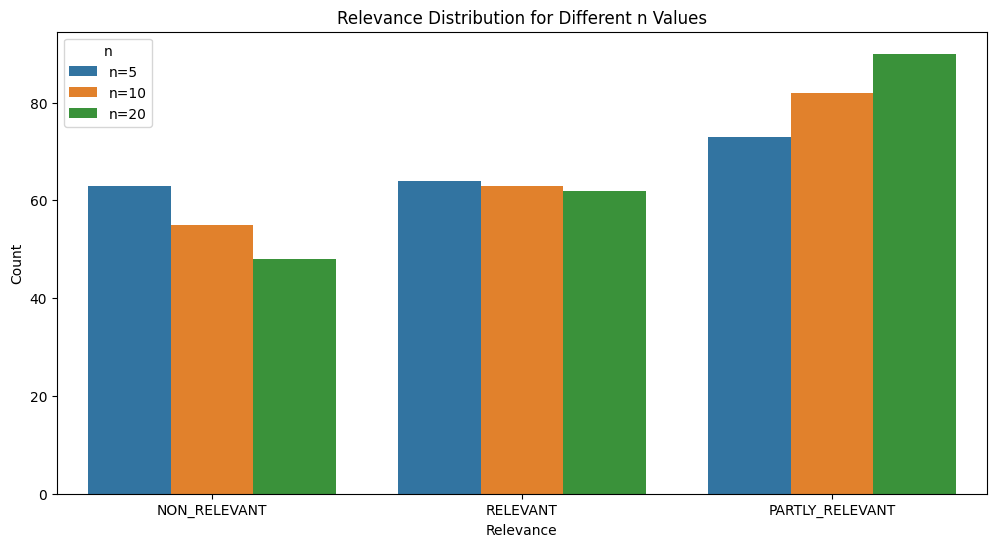

n     relevance      
n=10  PARTLY_RELEVANT    0.410
      RELEVANT           0.315
      NON_RELEVANT       0.275
n=20  PARTLY_RELEVANT    0.450
      RELEVANT           0.310
      NON_RELEVANT       0.240
n=5   PARTLY_RELEVANT    0.365
      RELEVANT           0.320
      NON_RELEVANT       0.315
Name: proportion, dtype: float64


In [148]:
plot_relevance_distribution(df_ss_eval_n5, df_ss_eval_n10, df_ss_eval_n20)

In [149]:
evaluate(ss_gt_docs, lambda q: ss_rag.elasticsearch(q['question'],n_results=5))

100%|██████████| 770/770 [02:23<00:00,  5.37it/s]


{'hit_rate': 0.36363636363636365, 'mmr': 0.3025541125541126}

In [150]:
evaluate(ss_gt_docs, lambda q: ss_rag.elasticsearch(q['question'],n_results=10))

100%|██████████| 770/770 [02:28<00:00,  5.19it/s]


{'hit_rate': 0.3974025974025974, 'mmr': 0.3081601731601731}

In [151]:
evaluate(ss_gt_docs, lambda q: ss_rag.elasticsearch(q['question'],n_results=20))

100%|██████████| 770/770 [02:27<00:00,  5.22it/s]


{'hit_rate': 0.43896103896103894, 'mmr': 0.3171454936019087}

For sentence splitting the best alternative is n=20

### Semantic chunking

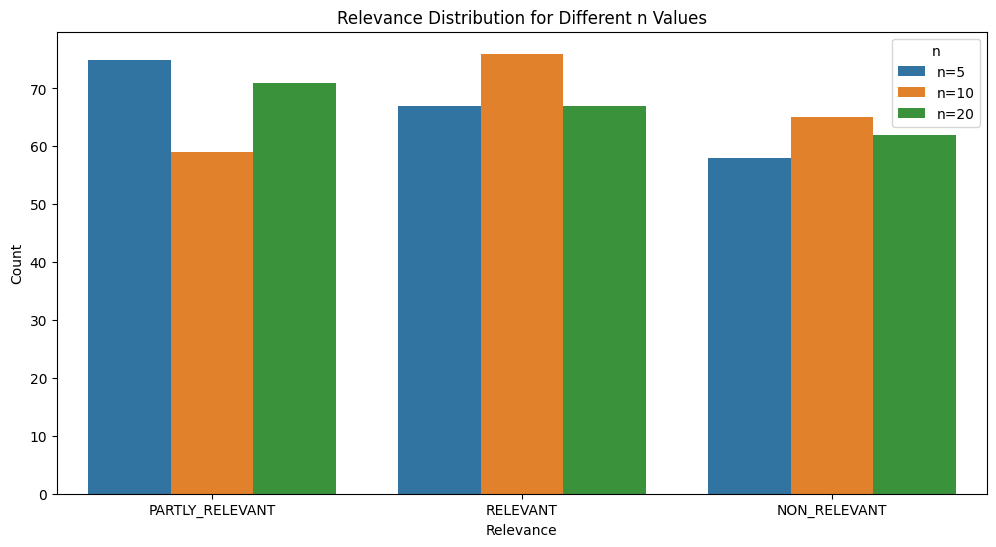

n     relevance      
n=10  RELEVANT           0.380
      NON_RELEVANT       0.325
      PARTLY_RELEVANT    0.295
n=20  PARTLY_RELEVANT    0.355
      RELEVANT           0.335
      NON_RELEVANT       0.310
n=5   PARTLY_RELEVANT    0.375
      RELEVANT           0.335
      NON_RELEVANT       0.290
Name: proportion, dtype: float64


In [161]:
plot_relevance_distribution(df_sc_eval_n5, df_sc_eval_n10, df_sc_eval_n20)

In [153]:
print(
    evaluate(sc_gt_docs, lambda q: sc_rag.elasticsearch(q['question'],n_results=5))
)
print(
    evaluate(sc_gt_docs, lambda q: sc_rag.elasticsearch(q['question'],n_results=10))
)
print(
    evaluate(sc_gt_docs, lambda q: sc_rag.elasticsearch(q['question'],n_results=20))
)

100%|██████████| 770/770 [02:21<00:00,  5.45it/s]


{'hit_rate': 0.509090909090909, 'mmr': 0.4250649350649349}


100%|██████████| 770/770 [02:37<00:00,  4.89it/s]


{'hit_rate': 0.5363636363636364, 'mmr': 0.4274397031539888}


100%|██████████| 770/770 [02:39<00:00,  4.81it/s]


{'hit_rate': 0.577922077922078, 'mmr': 0.4303191032159509}


### Sequential Semantic Chunking

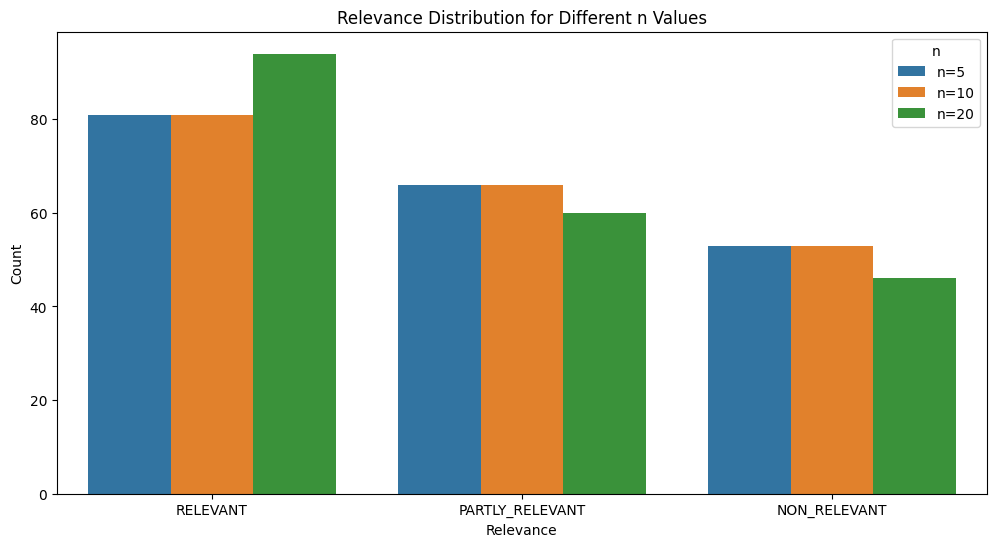

n     relevance      
n=10  RELEVANT           0.405
      PARTLY_RELEVANT    0.330
      NON_RELEVANT       0.265
n=20  RELEVANT           0.470
      PARTLY_RELEVANT    0.300
      NON_RELEVANT       0.230
n=5   RELEVANT           0.405
      PARTLY_RELEVANT    0.330
      NON_RELEVANT       0.265
Name: proportion, dtype: float64


In [162]:
plot_relevance_distribution(df_ssc_eval_n5, df_ssc_eval_n10, df_ssc_eval_n20)

In [163]:
print(
    evaluate(ssc_gt_docs, lambda q: ssc_rag.elasticsearch(q['question'],n_results=5))
)
print(
    evaluate(ssc_gt_docs, lambda q: ssc_rag.elasticsearch(q['question'],n_results=10))
)
print(
    evaluate(ssc_gt_docs, lambda q: ssc_rag.elasticsearch(q['question'],n_results=20))
)

100%|██████████| 770/770 [02:28<00:00,  5.17it/s]


{'hit_rate': 0.5727272727272728, 'mmr': 0.4379220779220776}


100%|██████████| 770/770 [02:34<00:00,  4.98it/s]


{'hit_rate': 0.6337662337662338, 'mmr': 0.4343532261389403}


100%|██████████| 770/770 [02:39<00:00,  4.82it/s]

{'hit_rate': 0.6935064935064935, 'mmr': 0.4245872798657163}


Given the results obtained with the sequential semantic chunking, which were progresively better as n grow bigger, we will also test for n=30 and n=50, as check for some different options for alpha:

n = 30

In [164]:
ssc_evaluations_n30 = []
for record in tqdm(ssc_sample):
    
    question = record['question']
    rag_answer = ssc_rag.answer(question, search="elasticsearch", n_results=30)
    time.sleep(5)
    prompt = evaluation_prompt_template.format(
        question=question,llm_answer=rag_answer
    )
    evaluation = ssc_rag.llm(prompt)
    evaluation = json.loads(evaluation[0])
    
    ssc_evaluations_n30.append((record, rag_answer, evaluation))
    
    time.sleep(5)  


100%|██████████| 200/200 [56:22<00:00, 16.91s/it]


In [165]:
df_ssc_eval_n30 = pd.DataFrame(
    ssc_evaluations_n30, columns=["record", "answer", "evaluation"]
)

df_ssc_eval_n30['id'] = df_ssc_eval_n30.record.apply(lambda d: d['id'])
df_ssc_eval_n30['question'] = df_ssc_eval_n30.record.apply(lambda d: d['question'])

df_ssc_eval_n30['relevance'] = df_ssc_eval_n30.evaluation.apply(lambda d: d['Relevance'])
df_ssc_eval_n30['explanation'] = df_ssc_eval_n30.evaluation.apply(lambda d: d['Explanation'])

del df_ssc_eval_n30['record']
del df_ssc_eval_n30['evaluation']

df_ssc_eval_n30.to_csv(
    os.path.join(project_path, "data", "testing", "rag-eval-ssc-n30.csv")
)

In [10]:
# df_ssc_eval_n30 = pd.read_csv(
#     os.path.join(project_path, 'data', 'testing', 'rag-eval-ssc-n30.csv')
# )

n = 50

In [13]:
ssc_evaluations_n50 = []
for record in tqdm(ssc_sample):
    
    question = record['question']
    rag_answer = ssc_rag.answer(question, search="elasticsearch", n_results=30)
    time.sleep(5)
    prompt = evaluation_prompt_template.format(
        question=question,llm_answer=rag_answer
    )
    evaluation = ssc_rag.llm(prompt)
    evaluation = json.loads(evaluation[0])
    
    ssc_evaluations_n50.append((record, rag_answer, evaluation))
    
    time.sleep(5)  

100%|██████████| 200/200 [57:51<00:00, 17.36s/it] 


In [14]:
df_ssc_eval_n50 = pd.DataFrame(
    ssc_evaluations_n50, columns=["record", "answer", "evaluation"]
)

df_ssc_eval_n50['id'] = df_ssc_eval_n50.record.apply(lambda d: d['id'])
df_ssc_eval_n50['question'] = df_ssc_eval_n50.record.apply(lambda d: d['question'])

df_ssc_eval_n50['relevance'] = df_ssc_eval_n50.evaluation.apply(lambda d: d['Relevance'])
df_ssc_eval_n50['explanation'] = df_ssc_eval_n50.evaluation.apply(lambda d: d['Explanation'])

del df_ssc_eval_n50['record']
del df_ssc_eval_n50['evaluation']

df_ssc_eval_n50.to_csv(
    os.path.join(project_path, "data", "testing", "rag-eval-ssc-n50.csv")
)

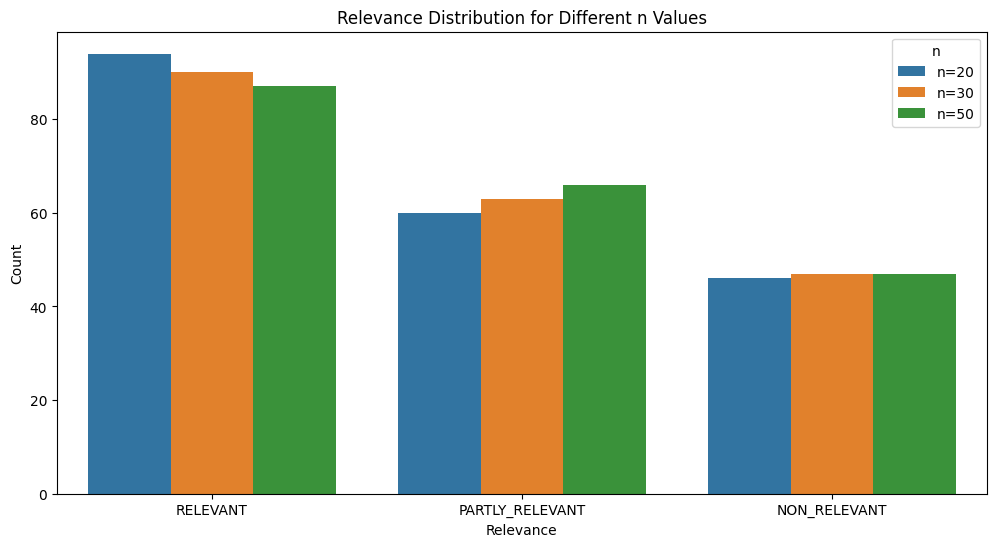

n     relevance      
n=20  RELEVANT           0.470
      PARTLY_RELEVANT    0.300
      NON_RELEVANT       0.230
n=30  RELEVANT           0.450
      PARTLY_RELEVANT    0.315
      NON_RELEVANT       0.235
n=50  RELEVANT           0.435
      PARTLY_RELEVANT    0.330
      NON_RELEVANT       0.235
Name: proportion, dtype: float64


In [17]:
def plot_relevance_distribution(df_eval_n20, df_eval_n30, df_eval_n50):
    """
    Plots the distribution of the 'relevance' column for the given dataframes.

    Args:
        df_eval_n20 (pd.DataFrame): DataFrame containing relevance data for n=20.
        df_eval_n30 (pd.DataFrame): DataFrame containing relevance data for n=30.
        df_eval_n50 (pd.DataFrame): DataFrame containing relevance data for n=50.

    Returns:
        None
    """
    # Create copies of the dataframes to avoid modifying the original dataframes
    df_eval_n20_copy = df_eval_n20.copy()
    df_eval_n30_copy = df_eval_n30.copy()
    df_eval_n50_copy = df_eval_n50.copy()
    
    # Add 'n' column to each copied dataframe
    df_eval_n20_copy['n'] = 'n=20'
    df_eval_n30_copy['n'] = 'n=30'
    df_eval_n50_copy['n'] = 'n=50'
    
    # Combine the copied dataframes into a single dataframe for plotting
    combined_df = pd.concat([df_eval_n20_copy, df_eval_n30_copy, df_eval_n50_copy])
    
    # Plot the distribution of the 'relevance' column
    plt.figure(figsize=(12, 6))
    sns.countplot(data=combined_df, x='relevance', hue='n')
    plt.title('Relevance Distribution for Different n Values')
    plt.xlabel('Relevance')
    plt.ylabel('Count')
    plt.legend(title='n')
    plt.show()
    
    # Print the value counts for the combined dataframe grouped by 'n'
    print(combined_df.groupby('n')['relevance'].value_counts(normalize=True))
    
plot_relevance_distribution(df_ssc_eval_n20, df_ssc_eval_n30, df_ssc_eval_n50)

In [18]:
print(
    evaluate(ssc_gt_docs, lambda q: ssc_rag.elasticsearch(q['question'],n_results=20))
)
print(
    evaluate(ssc_gt_docs, lambda q: ssc_rag.elasticsearch(q['question'],n_results=30))
)
print(
    evaluate(ssc_gt_docs, lambda q: ssc_rag.elasticsearch(q['question'],n_results=50))
)

100%|██████████| 770/770 [02:32<00:00,  5.03it/s]


{'hit_rate': 0.6935064935064935, 'mmr': 0.4245872798657163}


100%|██████████| 770/770 [02:34<00:00,  4.99it/s]


{'hit_rate': 0.7285714285714285, 'mmr': 0.41658238608814924}


100%|██████████| 770/770 [02:37<00:00,  4.90it/s]

{'hit_rate': 0.7727272727272727, 'mmr': 0.40957117519382896}


As we can see after 20 once our n gets bigger the relevance of the model's responses start beign worst, as does the MMR. While the hit rate does go up (which was to be expected since we are making the pool of returned answers bigger) it seems that the ammount of non relevant information starts affecting the quality of the rag responses. Therefore, we will use n=20 elements. 

Finally, we check for different values of alpha:

In [19]:
print(
    evaluate(ssc_gt_docs, lambda q: ssc_rag.elasticsearch(
        q['question'], 
        n_results=20,
        alpha=0.85
    ))
)
print(
    evaluate(ssc_gt_docs, lambda q: ssc_rag.elasticsearch(
        q['question'], 
        n_results=20,
        alpha=0.8
    ))
)
print(
    evaluate(ssc_gt_docs, lambda q: ssc_rag.elasticsearch(
        q['question'], 
        n_results=20,
        alpha=0.7
    ))
)
print(
    evaluate(ssc_gt_docs, lambda q: ssc_rag.elasticsearch(
        q['question'], 
        n_results=20,
        alpha=0.6
    ))
)
print(
    evaluate(ssc_gt_docs, lambda q: ssc_rag.elasticsearch(
        q['question'], 
        n_results=20,
        alpha=0.5
    ))
)

100%|██████████| 770/770 [02:32<00:00,  5.05it/s]


{'hit_rate': 0.6766233766233766, 'mmr': 0.4172665759403321}


100%|██████████| 770/770 [02:35<00:00,  4.94it/s]


{'hit_rate': 0.6727272727272727, 'mmr': 0.412622986620061}


100%|██████████| 770/770 [02:45<00:00,  4.66it/s]


{'hit_rate': 0.6571428571428571, 'mmr': 0.4010129772567951}


100%|██████████| 770/770 [02:35<00:00,  4.95it/s]


{'hit_rate': 0.6532467532467533, 'mmr': 0.3963742731341537}


100%|██████████| 770/770 [02:43<00:00,  4.72it/s]

{'hit_rate': 0.6532467532467533, 'mmr': 0.39319251242505215}


In [20]:
print(
    evaluate(ssc_gt_docs, lambda q: ssc_rag.elasticsearch(
        q['question'], 
        n_results=20,
        alpha=0.95
    ))
)
print(
    evaluate(ssc_gt_docs, lambda q: ssc_rag.elasticsearch(
        q['question'], 
        n_results=20,
        alpha=1
    ))
)

100%|██████████| 770/770 [02:38<00:00,  4.87it/s]


{'hit_rate': 0.7610389610389611, 'mmr': 0.43919581313860795}


100%|██████████| 770/770 [02:41<00:00,  4.77it/s]

{'hit_rate': 0.7935064935064935, 'mmr': 0.4490562441949596}


como se puede ver, la busqueda sematica pura resulta mucho mejor en este caso que la hybrida. Así, utilizaremos un alpha de 1

## Saving best model cofiguration

Finally we will save the configuration for the RAG that gave the best performance. We will also upload them to gcs storage, since this will be later adressed again when thinking of our cloud deployment

In [21]:
from src.storage import StorageManager

GCP_PROJECT_ID=os.getenv('GCP_PROJECT_ID')
BUCKET=os.getenv('BUCKET')

storage_manager = StorageManager(gcp_project=GCP_PROJECT_ID, bucket_name=BUCKET)


c:\Users\User\Documents\Cursos\llm_zoomcamp_final_project\llm-project\Lib\site-packages\google\auth\_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [23]:
rag_config = {
    "n_results":20,
    "boost_dict":ssc_rag.boost_dict,
    "alpha":1
}
config_file = os.path.join(project_path, "src", "parameters", "rag_config.json")
with open(config_file, "w") as file:
    json.dump(rag_config, file)

In [24]:
storage_manager.upload_file(config_file, "rag_config.json")